In [11]:
#Ref1: https://www.analyticsvidhya.com/blog/2019/01/neural-machine-translation-keras/
#Ref2: https://machinelearningmastery.com/develop-neural-machine-translation-system-keras/

from pickle import load

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
import os
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
import keras
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 200)

from keras import backend as K
from keras import __version__
print('Using Keras version:', __version__, 'backend:', K.backend())

Using Keras version: 2.4.3 backend: tensorflow


In [12]:
def read_dataset(file_path):
    #Open from .txt files
    dataset = []
    with open(file_path, encoding='utf-8') as f:
        dataset = f.readlines()
        f.close()
    return dataset

def split_input_target(dataset):
    datasetLength = len(dataset)

    # Split into English Sentence and Portuguese Sentences
    eng_sen =  [] #English Sentence
    port_sen =  [] #Portuguese Sentence

    for line in dataset:
        splited = line.split('|')
        eng_sen.append(splited[0])
        port_sen.append(splited[1])

    return [eng_sen, port_sen]


In [13]:
def cleaning_punctuation_and_uppercase(sentence_list):
    sentence_list  = [(sen.translate(str.maketrans('', '', string.punctuation))).lower() for sen in sentence_list]
    return sentence_list

def visualize_length_of_sentences(title, senX, senY):
    senX = [len(sen.split()) for sen in senX]
    senY = [len(sen.split()) for sen in senY]
    length_df = pd.DataFrame({'English': senX, 'Portuguese': senY})
    length_df.hist(bins = 30)
    plt.xticks(range(0, 15, 1))
    plt.xlabel('#Word', fontsize=18)
    plt.ylabel('#Sentences', fontsize=16)
    fig = plt.figure()
    fig.suptitle(title, fontsize=20)
    #fig.save(title+".jpg")
    plt.show()

In [14]:
def tokenizer(sentence_list):
    tok = tf.keras.preprocessing.text.Tokenizer()
    tok.fit_on_texts(sentence_list)
    return  tok #tok.sequences_to_matrix(tok.texts_to_sequences(sentence_list), mode='tfidf')

# Text Encoding into sequences and pad to make equal feature length to Train NN
def encode_text_to_sequences(tokenizer, max_sen_length, sentence_list):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(sentence_list)
    # pad sequences with 0 values
    seq = keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_sen_length, padding='post')
    return seq

def max_length(data):
    mx = 0
    for i in range(len(data)):
        mx = max(mx, len(data[i]))
    return mx

# Validation Data Process
validation_dataset = read_dataset("dev.txt")
val_eng_sen, val_port_sen = split_input_target(validation_dataset)

val_eng_sen = cleaning_punctuation_and_uppercase(val_eng_sen)
val_port_sen = cleaning_punctuation_and_uppercase(val_port_sen)

print('Validation English Datalen: '+str(len(val_eng_sen)))
print('Validation Portugu Datalen: '+str(len(val_port_sen)))

# Test Data Process
test_dataset = read_dataset("test.txt")
test_eng_sen, test_port_sen = split_input_target(test_dataset)

test_eng_sen = cleaning_punctuation_and_uppercase(test_eng_sen)
test_port_sen = cleaning_punctuation_and_uppercase(test_port_sen)

print('Test English Datalen: '+str(len(test_eng_sen)))
print('Test Portugu Datalen: '+str(len(test_port_sen)))
    

Validation English Datalen: 60294
Validation Portugu Datalen: 60294
Test English Datalen: 67865
Test Portugu Datalen: 67865


In [15]:
    dataset = read_dataset("dataset_2.txt")

    #dataset = read_dataset(root + 'datasets/modified_datasets/dataset_'+str(i)+'.txt')
    eng_sen, port_sen = split_input_target(dataset)

    #Cleaning
    eng_sen = cleaning_punctuation_and_uppercase(eng_sen)
    port_sen = cleaning_punctuation_and_uppercase(port_sen)

    #Plot Sentences
    #visualize_length_of_sentences("modified dataset "+str(i), eng_sen, port_sen)

    #tokenize
    eng_tok = tokenizer(eng_sen+val_eng_sen+test_eng_sen)
    port_tok = tokenizer(port_sen+val_port_sen+test_port_sen)

    #Max word length in Sentence
    max_eng_sen_word_length  = max_length(eng_sen+val_eng_sen+test_eng_sen)
    max_port_sen_word_length = max_length(port_sen+val_port_sen+test_port_sen)

    #Vocab Size
    eng_vocab_size = len(eng_tok.word_index)+1
    port_vocab_size = len(port_tok.word_index)+1
    print('English Vocab Size: ' + str(eng_vocab_size))
    print('Portugu Vocab Size: ' + str(port_vocab_size))

    #train encoding text to sequence
    train_eng_enc_seq = encode_text_to_sequences(eng_tok, max_eng_sen_word_length, eng_sen)
    train_port_enc_seq = encode_text_to_sequences(port_tok, max_port_sen_word_length, port_sen)

    #validation enc text to seq
    val_eng_enc_seq = encode_text_to_sequences(eng_tok, max_eng_sen_word_length, val_eng_sen)
    val_port_enc_seq = encode_text_to_sequences(port_tok, max_port_sen_word_length, val_port_sen)

    #test enc text to seq
    test_eng_enc_seq = encode_text_to_sequences(eng_tok, max_eng_sen_word_length, test_eng_sen)
    test_port_enc_seq = encode_text_to_sequences(port_tok, max_port_sen_word_length, test_port_sen)



English Vocab Size: 1794
Portugu Vocab Size: 6517


In [16]:
# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, hidden_size):
  use_dropout = True
  model = Sequential()
  model.add(Embedding(src_vocab, hidden_size, input_length = src_timesteps))
  model.add(LSTM(hidden_size))
  model.add(RepeatVector(tar_timesteps))
  model.add(LSTM(hidden_size, return_sequences=True))
  if use_dropout:
    model.add(Dropout(0.5))
  model.add(TimeDistributed(Dense(tar_vocab, activation = 'softmax')))
  
  return model

# define model
model = define_model(eng_vocab_size, port_vocab_size, max_eng_sen_word_length, max_port_sen_word_length, 256)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
# summarize defined model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 65, 256)           459264    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 86, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 86, 256)           525312    
_________________________________________________________________
dropout (Dropout)            (None, 86, 256)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 86, 6517)          1674869   
Total params: 3,184,757
Trainable params: 3,184,757
Non-trainable params: 0
______________________________________________

Epoch 1/5
1304/1304 [==============================] - 122s 68ms/step - loss: 0.9455 - val_loss: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.00000, saving model to model.h1.04_apr_21


INFO:tensorflow:Assets written to: model.h1.04_apr_21/assets


INFO:tensorflow:Assets written to: model.h1.04_apr_21/assets


Epoch 2/5
1304/1304 [==============================] - 90s 69ms/step - loss: 0.5411 - val_loss: 0.0000e+00

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/5
1304/1304 [==============================] - 90s 69ms/step - loss: 0.5343 - val_loss: 0.0000e+00

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/5
1304/1304 [==============================] - 90s 69ms/step - loss: 0.5297 - val_loss: 0.0000e+00

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/5
1304/1304 [==============================] - 90s 69ms/step - loss: 0.5274 - val_loss: 0.0000e+00

Epoch 00005: val_loss did not improve from 0.00000


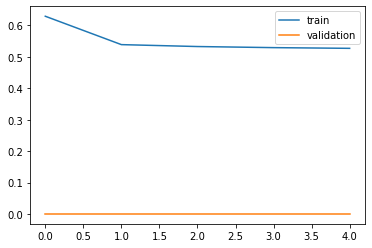

In [17]:
filename = 'model.h1.04_apr_21'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(train_eng_enc_seq, train_port_enc_seq, epochs=5, batch_size=64, validation_split=0, validation_data = [val_eng_enc_seq, val_port_enc_seq], callbacks = [checkpoint], verbose=1)

#model.save('model.h1.04_apr_21')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()